<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/main/notebooks/Python_chapter_WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Web操作・スクレイピング

Webから情報を抽出・整形・解析したり、  
ブラウザ上での特定の操作を自動化する、といったことも  
Pythonでは比較的容易に実行することができる。

Web上にある情報にアクセスしたりする方法は色々あるが、大まかには２つに分類され

1. プログラムでWebページにアクセスして中身(HTML)を読み、そこから情報を抽出する方法
2. ブラウザをプログラムに操作させて特定の作業を実行する方法

この章では、とくに1.のWebから情報を抽出すること(スクレイピング)に絞ってそのエッセンスを紹介する。  
HTMLとは、Webページを作るための言語のことで、  
みなさんが普段からアクセスするほぼ全てのWebページは、  
HTMLで記述されています。


Webから情報を抽出したりする際、共通して言える注意点を述べておく:
* **対象とするページの利用規約を必ず確認する**  
規約でスクレイピングを禁止しているページがある (例: Amazon, Twitter, Instagram, facebook, 金融系などなど)  
    禁止している場合でも、APIが提供されている場合があります  
    ※APIはApplication Programming Interfaceの略です。  
    今の場合、大雑把にはデータ提供用の窓口とでも思ってください.

* **サーバーに負荷をかけない**  
    規約で特にスクレイピングを禁止していない場合でも、過度なアクセスをしてはいけません。  
    (どこかの大学の教務ポータルみたいに落ちてしまったら大変です)   
    過度なアクセスは、悪意のあるDos攻撃とみなされてアクセスを制限されたり、  
    最悪の場合、偽計業務妨害罪などの罪に問われる可能性があります。






## 東京都の新型コロナウイルス関連情報の取得

スクレイピングを可能とするライブラリは多数存在する。  
代表的なものは```requests```や```urllib```。以下では```requests```を使います。  

JavaScriptの実行などがないページならこれでだいたい十分かと思います.  
また```BeutifulSoup4```というライブラリを使うと、HTMLを構文解析して、  
タグなどを取り除くといった操作が比較的容易に行えます。



1つ目の例として、[東京都 新型コロナウイルス感染症対策サイト](https://stopcovid19.metro.tokyo.lg.jp/)の公開データを取得して  
それをグラフにして可視化してみましょう。まずは必要なライブラリをインポートしておきます。

In [ ]:
import requests
import json
import datetime
import matplotlib.pyplot as plt
!pip install japanize-matplotlib 
import japanize_matplotlib 

[東京都 新型コロナウイルス感染症対策サイト](https://stopcovid19.metro.tokyo.lg.jp/)の[レポジトリ](https://github.com/tokyo-metropolitan-gov/covid19)で公開されているデータ(json形式)を読み出す。

指定したurlにリクエストを送り、レスポンスをjson形式で取得する

In [ ]:
url = "https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json"
response = requests.get(url)
data = response.json()

上の`data`を直接`print`すると表示が冗長になるため  
代わりに、jsonのキーとして何があるかを見てみよう。

In [ ]:
data.keys()

dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])

それぞれ
* contacts: 新型コロナコールセンター相談件数
* querents: 帰国者・接触者電話相談センター相談件数
* patients_summary: 陽性患者数
* inspections_summary: 検査実施日別状況
* lastUpdate: 最終更新日時
* main_summary: (これはよくわからない)

に対応している。

陽性患者数のデータの構造を調べつつ結果を可視化してみよう。  
まずは型を調べてみる。

In [ ]:
type(data['patients_summary'])

<class 'dict'>


辞書型とわかったのでキーの一覧を見てみよう

In [ ]:
data['patients_summary'].keys()

dict_keys(['date', 'data'])

同様にして`data['patients_summary']["data"]`が"日付"と"小計"をキーに持つ辞書のリストだと分かる。

In [ ]:
data['patients_summary']["data"][0]

{'日付': '2020-01-24T08:00:00.000Z', '小計': 1}

日付と陽性患者数をリストに直して、描画してみよう

In [ ]:
#　"2022-01-01"のような文字列をdatetimeに変換する関数
def str_to_dt(tstr):
    tdatetime = datetime.datetime.strptime(tstr, '%Y-%m-%d')
    tdate = datetime.date(tdatetime.year, tdatetime.month, tdatetime.day)
    return tdate
    
tdat = data['patients_summary']["data"]
N = len(tdat)
tdat = data['patients_summary']["data"]
dates = [ str_to_dt(tdat[i]["日付"].split("T")[0]) for i in range(N)]
num_patients = [ tdat[i]['小計'] for i in range(N)]
print(dates)
print(num_patients)

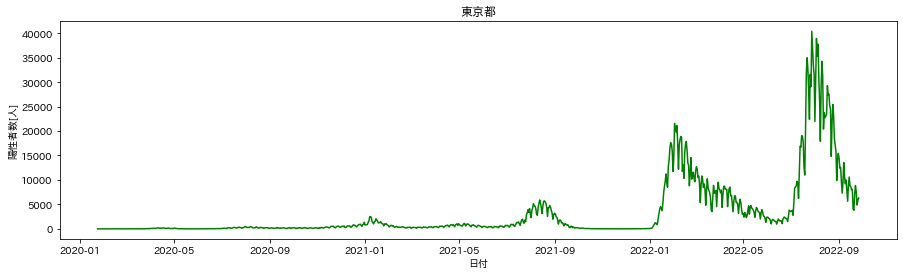

In [ ]:
fig = plt.figure(figsize=(15,4))
plt.title("東京都")
plt.xlabel("日付")
plt.ylabel("陽性者数[人]")
plt.plot(dates,num_patients, color="green")
plt.show()
plt.close()

## e-Statのデータを取得する

[政府統計の総合窓口(e-Stat)](https://www.e-stat.go.jp/)は  
日本の各府省が公表する統計データを一つにまとめた、   
政府統計のポータルサイトです。

e-Statでは[API機能](https://www.e-stat.go.jp/api/)(ユーザー登録が必要)が提供されていて、  
指定されたURLに対してリクエストを送信することで各APIを利用することが出来ます。




### 準備1 e-Statの登録






以降の内容でも、e-StatのAPI機能を使用するため予めe-Statへの登録が必要です。

国内のデータを使って最終課題に取り組みたいという方は  
ここに記載の手順にならって登録しておきましょう。

1. まず[こちら](https://www.e-stat.go.jp/mypage/user/preregister)のページからメールアドレス(Gmailを推奨します)を入力し、届いたメールから本登録を行う  
このとき、gmailアカウントによる認証をオンにしておくと、以後のログインが楽。
2. [ログインページ](https://www.e-stat.go.jp/mypage/login)からログインし、
右上の[マイページ]に遷移
<img src="https://drive.google.com/uc?export=view&id=1NHMQ8GnJ6n6hSaUAIFgOGyRc5Z55Enxj" width = 70%>
3. [API機能(アプリケーションID発行)]に遷移する
4. 以下の例にならって、名称とURLを入力し、発行ボタンを押す
<img src="https://drive.google.com/uc?export=view&id=100w2nmie7ZD6PliQVbjAHIt7o5gaBciN" width = 80%>

5. [appId]に生成された文字列を、どこかに控えておく(**appIdを他人と共有してはいけません**)


### 準備2 Pandas e-Statのインストール


さて、e-Statへの登録ができたでしょうか。  

早速e-Statにあるデータをどんどん抽出したい  
...のですが、[マニュアル](https://www.e-stat.go.jp/api/sites/default/files/uploads/2019/07/API-specVer3.0.pdf)を理解してAPIに適切なリクエストを送るというのは、  
それ自体がややハードルが高いかと思います。

そこで、このノートブックでは[simaki](https://github.com/simaki)氏が作った  
Python用のライブラリ[Pandas e-Stat](https://github.com/simaki/pandas-estat)を使用することにします。  
同氏によるQiitaの解説記事→https://qiita.com/simaki/items/05cc242d27b4e6781d19

まずはインストール&インポートします。



In [ ]:
!pip install pandas-estat
import pandas as pd
## import pandas_estat 
# 以降では、pandas_estat内の関数は個別にimportすることにする (そうすると短い名前で使える)
#実行時の依存関係のエラーは当面問題ない(はず)

次に```pandas_estat```からAPIを使用するためのIDを指定します

In [ ]:
from pandas_estat import set_appid
appID = "honyahonya" # 引用符内を準備1で発行したappidに置き換える
set_appid(appID) 

## Pandas e-Statを使ってみよう

ライブラリを使ってみましょう.  
```read_statslist()```関数の引数に"政府統計コード"を指定することで、  
該当する統計データの一覧を```pandas.DataFrame```形式で取得することができます。  
[政府統計コードの一覧はこちら](https://www.e-stat.go.jp/help/stat-search-3-5)


政府統計コードそのものの一覧をdataframe形式取得するコードはそのうち書くつもりです。  


それでは、さっそくPandas e-statを使ってみましょう。  
以下では、例にならって「サービス産業動向調査」の結果を抽出してみることにしましょう。

In [ ]:
from pandas_estat import read_statslist
statslist = read_statslist("00200544")  # サービス産業動向調査
statslist

      TABLE_INF STAT_CODE  ... SUB_CATEGORY_CODE SUB_CATEGORY
0    0003179100  00200544  ...                02         需給流通
1    0003179101  00200544  ...                02         需給流通
2    0003085562  00200544  ...                02         需給流通
3    0003085612  00200544  ...                02         需給流通
4    0003090498  00200544  ...                02         需給流通
..          ...       ...  ...               ...          ...
137  0003412789  00200544  ...                02         需給流通
138  0003412790  00200544  ...                02         需給流通
139  0003412791  00200544  ...                02         需給流通
140  0003412792  00200544  ...                02         需給流通
141  0003412793  00200544  ...                02         需給流通

[142 rows x 35 columns]


次に、これらのデータがどうやって分類されているのかを調べてみましょう。  
列(column)を表示してみると

In [ ]:
print(statslist.columns)

Index(['TABLE_INF', 'STAT_CODE', 'STAT_NAME', 'GOV_ORG_CODE', 'GOV_ORG_NAME',
       'TABULATION_CATEGORY', 'TABULATION_SUB_CATEGORY1',
       'TABULATION_SUB_CATEGORY2', 'TABULATION_SUB_CATEGORY3',
       'TABULATION_SUB_CATEGORY4', 'TABULATION_SUB_CATEGORY5',
       'TABULATION_CATEGORY_EXPLANATION',
       'TABULATION_SUB_CATEGORY_EXPLANATION1',
       'TABULATION_SUB_CATEGORY_EXPLANATION2',
       'TABULATION_SUB_CATEGORY_EXPLANATION3',
       'TABULATION_SUB_CATEGORY_EXPLANATION4',
       'TABULATION_SUB_CATEGORY_EXPLANATION5', 'NO', 'TITLE',
       'TABLE_EXPLANATION', 'TABLE_CATEGORY', 'TABLE_SUB_CATEGORY1',
       'TABLE_SUB_CATEGORY2', 'TABLE_SUB_CATEGORY3', 'CYCLE', 'SURVEY_DATE',
       'OPEN_DATE', 'SMALL_AREA', 'COLLECT_AREA', 'OVERALL_TOTAL_NUMBER',
       'UPDATED_DATE', 'MAIN_CATEGORY_CODE', 'MAIN_CATEGORY',
       'SUB_CATEGORY_CODE', 'SUB_CATEGORY'],
      dtype='object')


例えば、```CYCLE```(周期)というものがあるので、  
CYCLEが"月次"(月ごと)になっているデータだけをピックアップして、  

In [ ]:
statslist = statslist[statslist.CYCLE == "月次"] 


その```TABLE_INF```(統計表ID)と```TITLE```(タイトル)だけを表示してみましょう

In [ ]:
statslist[["TABLE_INF", "TITLE"]]

     TABLE_INF                                              TITLE
2   0003085562    事業所・企業等の産業（中分類）別売上高，従業上の地位別事業従事者数（月次）【2013年1月～】
5   0003191203                     事業活動の産業（中分類）別売上高（月次）【2013年1月～】
7   0003085489               事業活動の産業（中分類）別需要の状況【2013年1月～2016年12月】
8   0003085521  事業活動の産業（中分類），事業所・企業等の産業（中分類）別売上高（月次）【2013年1月～12月】
10  0003094573  事業活動の産業（一部中分類），事業所・企業等の産業（一部中分類）別売上高（月次）【2013年...


```TABLE_INF```の数値が[統計表ID]と呼ばれるものです。

ではこの中から"事業活動の産業（中分類）別売上高（月次）【2013年1月～】"を読み出してみましょう。  
それには```read_statsdata```という関数が用意されているので、  
引数に```TABLE_INF```(統計表ID)を入力すると...

In [ ]:
from pandas_estat import read_statsdata 
df = read_statsdata("0003191203")  
df

     tab_code      表章項目 cat01_code 事業活動の産業  ...    時間軸（月次） unit     value annotation
0         001  売上高（収入額）      00000      合計  ...    2013年1月  百万円  27331888        NaN
1         001  売上高（収入額）      00000      合計  ...    2013年2月  百万円  27395304        NaN
2         001  売上高（収入額）      00000      合計  ...    2013年3月  百万円  35140562        NaN
3         001  売上高（収入額）      00000      合計  ...    2013年4月  百万円  28676427        NaN
4         001  売上高（収入額）      00000      合計  ...    2013年5月  百万円  28648626        NaN
...       ...       ...        ...     ...  ...        ...  ...       ...        ...
5035      001  売上高（収入額）      20000     その他  ...    2021年5月  百万円    869554        NaN
5036      001  売上高（収入額）      20000     その他  ...    2021年6月  百万円    956542        NaN
5037      001  売上高（収入額）      20000     その他  ...  2021年7月 p  百万円    937055        NaN
5038      001  売上高（収入額）      20000     その他  ...  2021年8月 p  百万円    894658        NaN
5039      001  売上高（収入額）      20000     その他  ...  2021年9月 p  百万円  

これで、データを抽出することができました。

In [ ]:
df.columns

Index(['tab_code', '表章項目', 'cat01_code', '事業活動の産業', 'area_code', '地域',
       'time_code', '時間軸（月次）', 'unit', 'value', 'annotation'],
      dtype='object')

もう属性を少し絞ってみましょう。

dataframeの"事業活動の産業"列にどんなものがあるかを抽出し、  
```set```関数を使って重複を除くと...

In [ ]:
set(df["事業活動の産業"])

{'37通信業',
 '38放送業',
 '39情報サービス業',
 '4*航空運輸業，郵便業（信書便事業を含む）',
 '40インターネット附随サービス業',
 '41映像・音声・文字情報制作業',
 '42鉄道業',
 '43道路旅客運送業',
 '44道路貨物運送業',
 '45水運業',
 '47倉庫業',
 '48運輸に附帯するサービス業',
 '68不動産取引業',
 '69不動産賃貸業・管理業',
 '70物品賃貸業',
 '72専門サービス業（他に分類されないもの）\u3000（※「純粋持株会社」（平成25年１月以降）を除く）',
 '73広告業',
 '74技術サービス業（他に分類されないもの）',
 '75宿泊業',
 '76飲食店',
 '77持ち帰り・配達飲食サービス業',
 '78洗濯・理容・美容・浴場業',
 '79その他の生活関連サービス業\u3000（※「家事サービス業」を除く）',
 '80娯楽業',
 '82aうち社会教育，職業・教育支援施設',
 '82bうち学習塾，教養・技能教授業',
 '82その他の教育，学習支援業',
 '83医療業',
 '84保健衛生\u3000（※「保健所」を除く）',
 '85社会保険・社会福祉・介護事業\u3000（※「社会保険事業団体」（平成25年１月以降）及び「福祉事務所」を除く）',
 '88廃棄物処理業',
 '89自動車整備業',
 '90機械等修理業（別掲を除く）',
 '91職業紹介・労働者派遣業',
 '92その他の事業サービス業',
 '95その他のサービス業',
 'その他',
 'サービス産業計',
 '合計',
 'Ｇ情報通信業',
 'Ｈ運輸業，郵便業',
 'Ｋ不動産業，物品賃貸業',
 'Ｌ学術研究，専門・技術サービス業\u3000（※「学術・開発研究機関」（平成25年１月以降）及び「純粋持株会社」（平成25年１月以降）を除く）',
 'Ｍ宿泊業，飲食サービス業',
 'Ｎ生活関連サービス業，娯楽業\u3000（※「家事サービス業」を除く）',
 'Ｏ教育，学習支援業\u3000（※「学校教育」を除く）',
 'Ｐ医療，福祉（※「保健所」、「社会保険事業団体」（平成25年１月以降）及び「福祉事務所」を除く）',
 'Ｒサービス業（他に分類されないもの）\u3000（

"42鉄道業"を見てみましょう。  

In [ ]:
ndf = df[df["事業活動の産業"] == "42鉄道業"] #dfの中の、"事業活動の産業欄が"42鉄道業"のものを抽出し、ndfと名前をつける

ndf = ndf[ndf["時間軸（月次）"].str.endswith("月")]
ndf["時間軸（月次）"] = pd.to_datetime(ndf["時間軸（月次）"], format="%Y年%m月")
ndf = ndf.sort_values("時間軸（月次）")

#必要なところだけ抽出すると...
ndf[["時間軸（月次）", "value", "unit"]]

        時間軸（月次）   value unit
945  2013-01-01  583438  百万円
946  2013-02-01  529656  百万円
947  2013-03-01  644219  百万円
948  2013-04-01  627287  百万円
949  2013-05-01  581344  百万円
...         ...     ...  ...
1042 2021-02-01  332987  百万円
1043 2021-03-01  424911  百万円
1044 2021-04-01  402705  百万円
1045 2021-05-01  341804  百万円
1046 2021-06-01  360438  百万円

[102 rows x 3 columns]
1.1.5


図を描いてみよう

In [ ]:
import matplotlib.pyplot as plt
!pip install japanize-matplotlib 
import japanize_matplotlib 
import matplotlib.dates as mdates

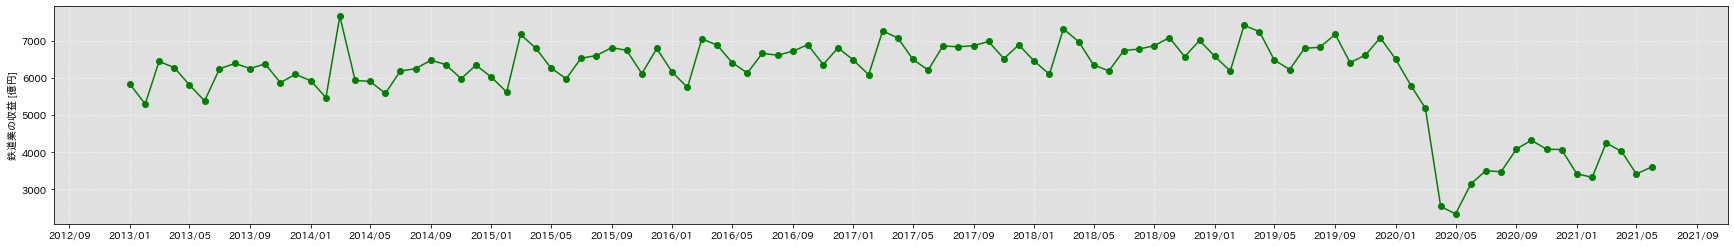

In [ ]:
x = ndf["時間軸（月次）"].values
y = ndf["value"].values.astype(float) * 1.e-2  # XX億円に換算

fig = plt.figure(figsize=(30, 4))
ax = fig.add_subplot(111)  
ax.set_facecolor("#e0e0e0")
ax.set_ylabel("鉄道業の収益 [億円]")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1, 13, 4)))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y/%m"))
ax.grid(True,axis="both",color="w", linestyle="dotted", linewidth=0.8)
ax.plot(x,y,marker="o",color="green")
plt.show()
plt.close()

新型コロナウイルスの感染拡大を受けて2020年の1月ごろから  
緊急事態宣言の解除(5月25日)まで、大幅に収益が減っていることが分かる。



---



### 備考

あらかじめ興味のあるデータ,分類・属性等がわかっている場合は、  
上記のコードの対応するIDなどを変更すればよいし  
コードを拡張して、データ,分類・属性等の一覧表などを適宜表示しながら、  
特定のキーワードを含むものに絞ってデータを取得したりもできる。

ちなみに、GoogleColabで提供されているコードスニペット(テンプレートのようなもの)  
を用いることで、プルダウンでデータ,分類・属性等を選んでプロットする、  
といったようにGoogle Colab.上で自分だけのe-Stat分析ツールを作ることもできる  
(最終課題で取り組むのも良い)
